# Basic Hand movements EMG Inferential Statistics
To support our hypothesis that there is a baseline signal for each grip accross all subjects, we must investigate how the signals might deviate from whatever baseline that can be calcuated. I will start with the mean, then test the samples to understand their distribution within the population we have available in the data. I will be using the data from `amp_adj_df` to calculate the baseline since it closely approximates the signal envelope.

criteria to accept the hypothesis: 
1. The signals grouped by grip must be statistically different.
    * The distribution of the signals grouped by grip must be checked to choose appropriate test.
    * We can also test how signals grouped by grip deviate from their calculated baseline.
2. The signals for subjects within a grip grouping must be statistically similar.


In [16]:
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy as sp
import matplotlib.pyplot as plt

# read in envelope_df and drop weird columns
df_envelope = pd.read_csv('envelope_df')
df_envelope = df_envelope.drop('Unnamed: 0', axis=1)
df_amp_adj = pd.read_csv('amp_adj_df')
df_amp_adj = df_amp_adj.drop('Unnamed: 0', axis=1)
df_amp_ol = pd.read_csv('amp_ol_df')
df_amp_ol = df_amp_ol.drop('Unnamed: 0', axis=1)

## Calculating a baseline using the mean
by averageing similar signals we can establish a first attempt at a baseline.

In [17]:
# seperate channel 1 from channel 2 and groupby grip_channel using mean as the aggregate function
ch1_mean_adj = df_amp_adj.loc[df_amp_adj['channel'] == 1].groupby('grip_channel').mean()
ch2_mean_adj = df_amp_adj.loc[df_amp_adj['channel'] == 2].groupby('grip_channel').mean()

Text(0.5,0,'sampling rate 10 Hz')

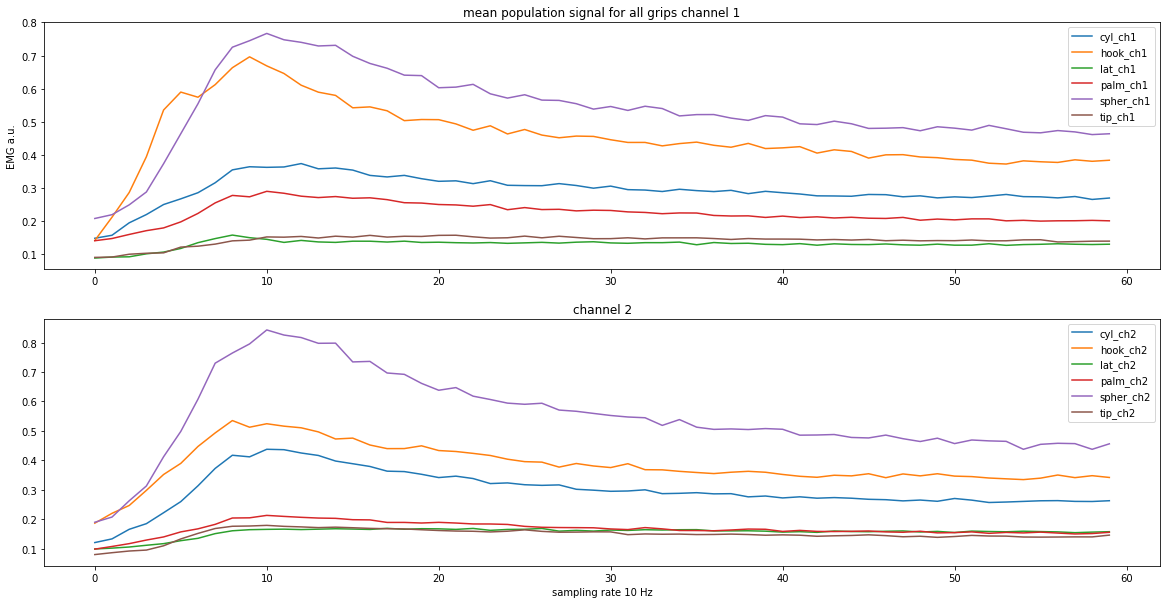

In [18]:
plt.figure(figsize=(20,10))

plt.subplot(2,1,1)

#loop over channel 1 rows containing signal data (60+ are categorical data)
for x, y in ch1_mean_adj.iloc[:,:60].iterrows():
    plt.plot(np.array(y)) # dont forget to set series as array to avoid graphing issues

plt.legend(ch1_mean_adj.index)
plt.title('mean population signal for all grips channel 1')
plt.ylabel('EMG a.u.')

plt.subplot(2,1,2)

#same for channel 2
for x, y in ch2_mean_adj.iloc[:,:60].iterrows():
    plt.plot(np.array(y))

plt.legend(ch2_mean_adj.index)
plt.title('channel 2')
plt.xlabel('sampling rate 10 Hz')

This is promising, but the mean signal might not be the appropriate test statistic if the distribution is not normal. Let's explore the distribution of the signals by grip to explore other degrees of centrality.

In [19]:
#seperate amp adj data into channel 1 and 2
channel_1 = df_amp_adj.loc[df_amp_adj['channel']==1]
channel_2 = df_amp_adj.loc[df_amp_adj['channel']==2]

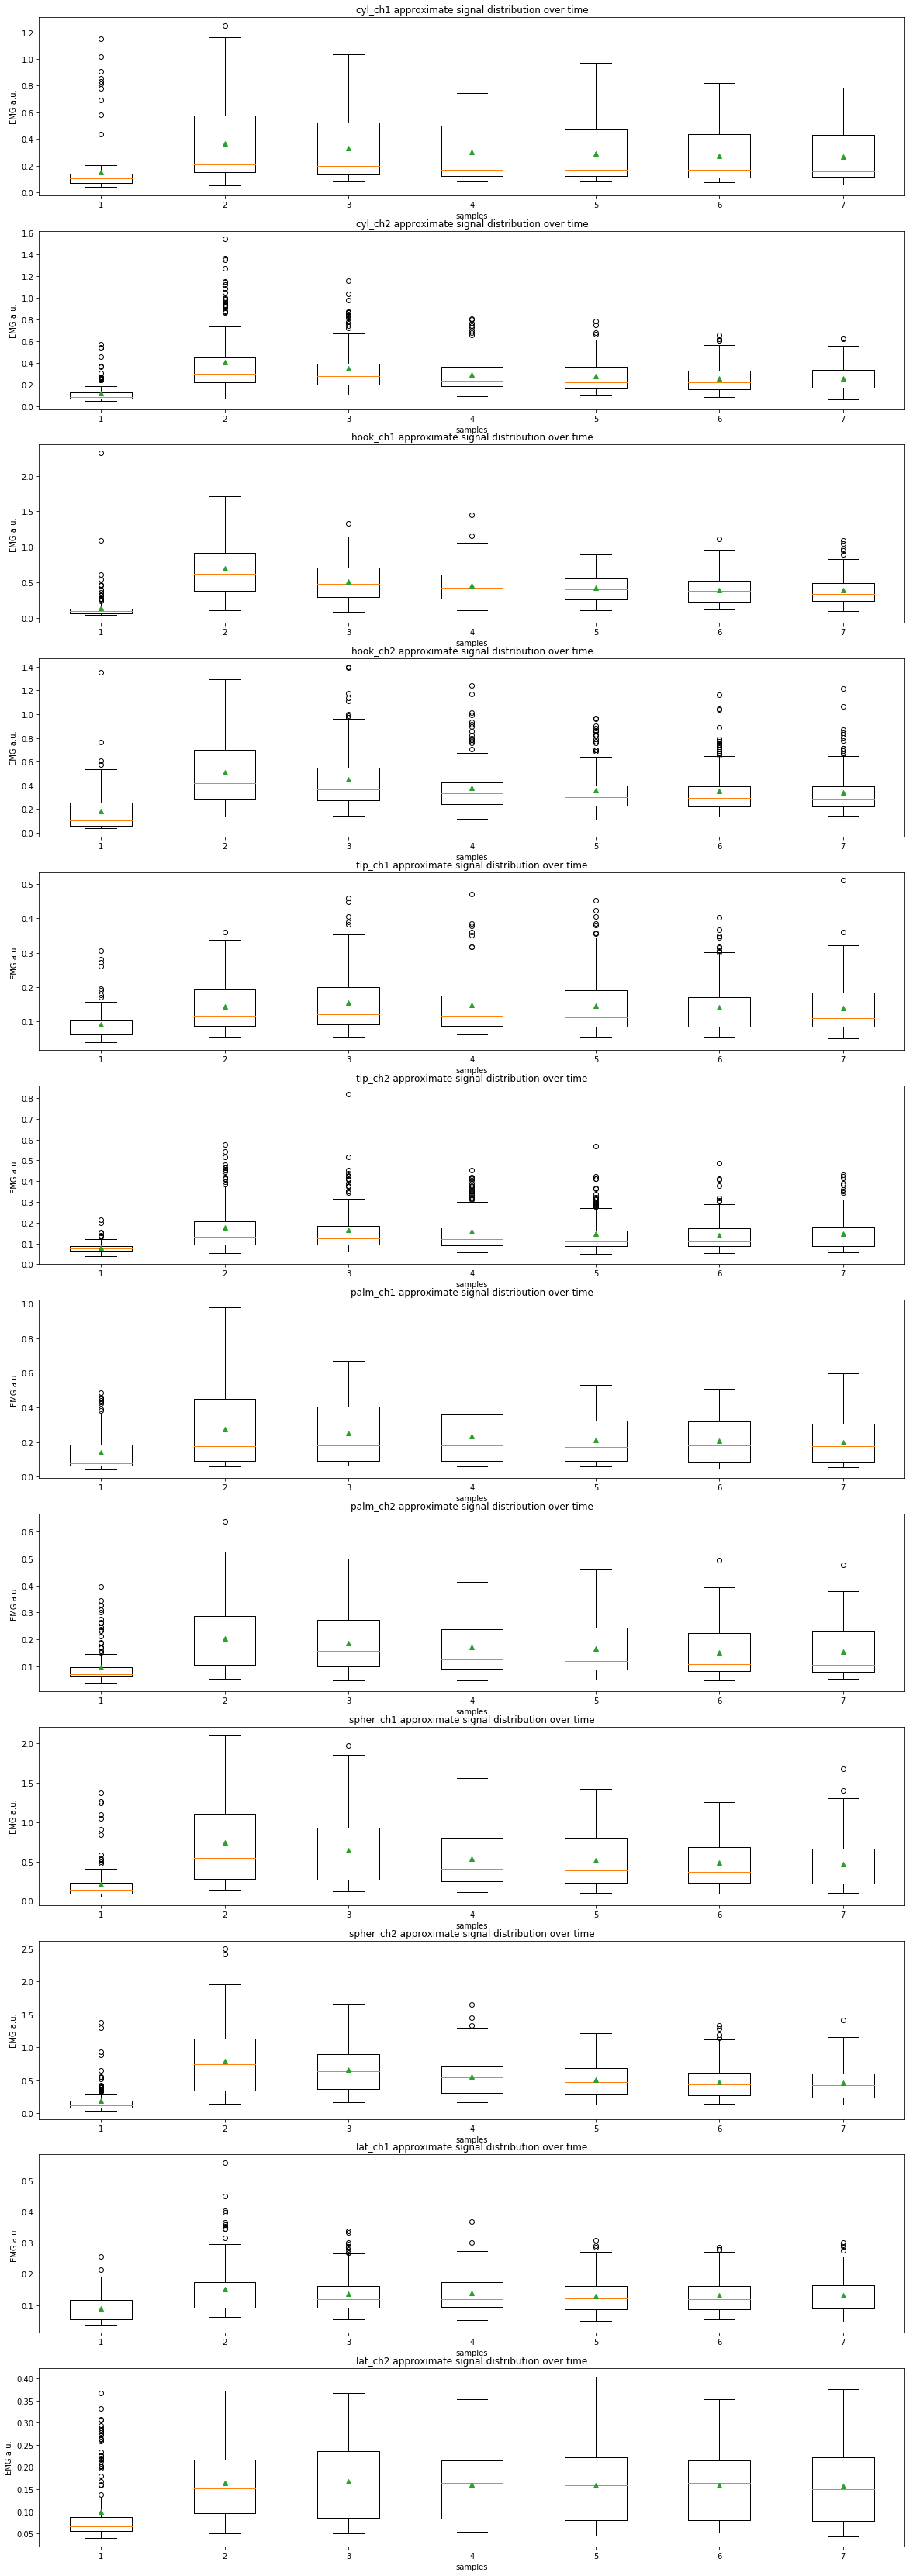

In [20]:
#list of all the grip_channel names
grip_channels = df_amp_adj['grip_channel'].unique()

subplot = 1

plt.figure(figsize=(20,60))

#loop over each grip
for i in grip_channels:
    grip_df = df_amp_adj.loc[df_amp_adj['grip_channel'] == i] #select samples for that grip_channel
    plt.subplot(12, 1, subplot)
    #graph boxplot for columns '0', '9', '19', '29', '39', '49', '59', one sample per second
    plt.boxplot([grip_df['0'],grip_df['9'],grip_df['19'],grip_df['29'],grip_df['39'],grip_df['49'],grip_df['59']], showmeans=True)
    plt.title('{} approximate signal distribution over time'.format(i))
    plt.xlabel('samples')
    plt.ylabel('EMG a.u.')
    subplot += 1

So apparently the distribution of the signals grouped by `grip_channel` is a right skewed normal distribution, so perhaps the median is a better measure of centrality, but remember that in this case we are most interested in capturing variety, so I still consider the mean to be a valuable measure of centrality in this data set, especially since in most cases the mean wasn't severely affected by outliers. To ensure that the mean is a useful measure of centrality, let us compute a confidence interval for each mean signal and observe for overlapping signals. 

In [21]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    
    "calculates the mean as well as the top and bottom values of the confidence interval"
    'data = a list or array of data'
    'confidence = size of confidence interval. default is 95%'
    
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h

def graph_signals(list_of_mean, list_of_bottom, list_of_top, label, num_of_samples=3000):
    
    "plot mean signal for all observations plus confidence interval"
    "list_of_mean = a list of  signals to plot"
    "list_of_bottom = list of values at bottom of 95% confidence interal of corresponding to list_of_mean"
    "list_of_top = list of values at top of 95% confidence interal of corresponding to list_of_mean"
    "num_of_samples = len of each array in list_of_mean. necessary to set fill between conf inter"
    "NOTE: MUST BE PASSED LISTS. IF YOU DONT PASS LISTS IT WILL DESTROY YOUR MEMORY"

    for x in list_of_mean:
        plt.plot(x, label=label)
    #plot confidence interval for all observations of female_1 channel 1
    for y1, y2 in zip(list_of_bottom, list_of_top):
        plt.plot(y1, c='r', alpha=0.5, linestyle='--')
        plt.plot(y2, c='r', alpha=0.5, linestyle='--')
        x = np.arange(0,num_of_samples,1)
        plt.fill_between(x,y1,y2,alpha=0.2)

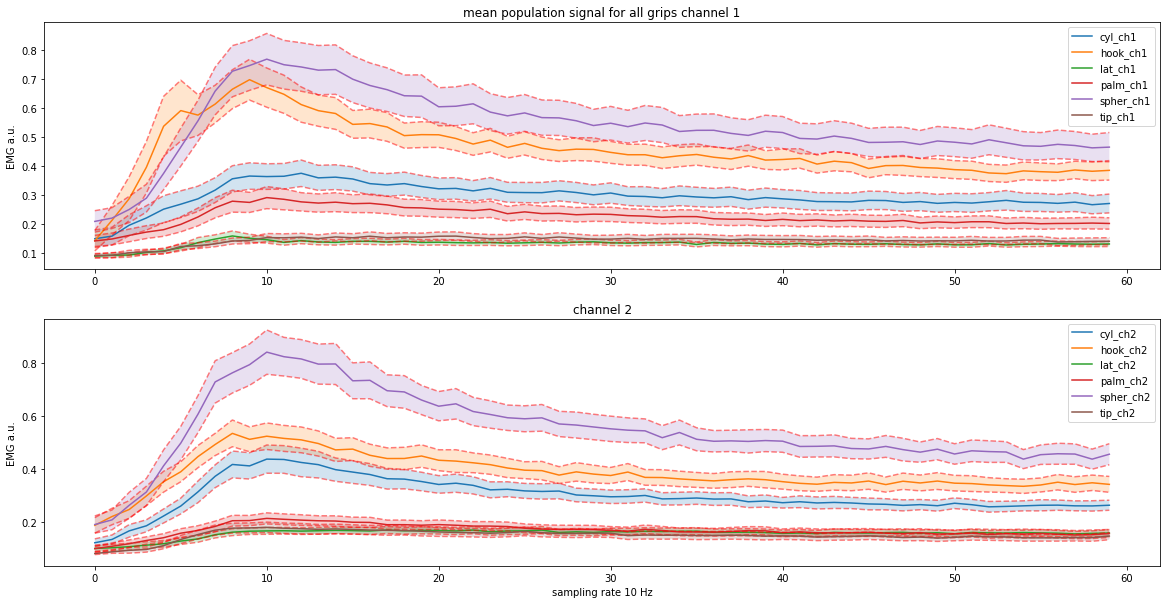

In [22]:
grips_all = [x for x in df_amp_adj.groupby(df_amp_adj['grip_channel'])]

plt.figure(figsize=(20,10))

plt.subplot(2,1,1)

#graph all channel 1 signals for channel 1
for x, y in grips_all[::2]:
    means = []
    bottoms = []
    tops = []
    #calculate mean and its confidence interval for each column
    for column in y.iloc[:,:60]:
        mean, bottom, top = mean_confidence_interval(np.array(y[column]))
        means.append(mean)
        bottoms.append(bottom)
        tops.append(top)
        
    graph_signals([means], [bottoms], [tops], label= x, num_of_samples=60)

plt.title('mean population signal for all grips channel 1')
plt.ylabel('EMG a.u.')
plt.legend()


plt.subplot(2,1,2)

#same as above but with channel 2 signals
for x, y in grips_all[1::2]:
    means = []
    bottoms = []
    tops = []
    for column in y.iloc[:,:60]:
        mean, bottom, top = mean_confidence_interval(np.array(y[column]))
        means.append(mean)
        bottoms.append(bottom)
        tops.append(top)
        
    graph_signals([means], [bottoms], [tops], label= x, num_of_samples=60)

plt.title('channel 2')
plt.xlabel('sampling rate 10 Hz')
plt.ylabel('EMG a.u.')


plt.legend()



We can see that after initial activation, the mean signal seems to stabilize within a range of about 0.2 activity units. Looking at the graph above, it is clear that a combination of the average of both channels makes a distinct description of each grip signal wise for all subjects (with an exception for both channels of tip and lat), but this isn't exactly helpful if the average signal doesn't accurately describe the variance within the population per grip signal. Before we test the statistical significance of the signals by grip, we must consider the distribution of the signals at cross sections.
## Are the signals grouped by grip statistically different?
First we must observe cross sections of the signals overlayed by grip to see what their distribution is and observe whether they might be considered part of the same population. 

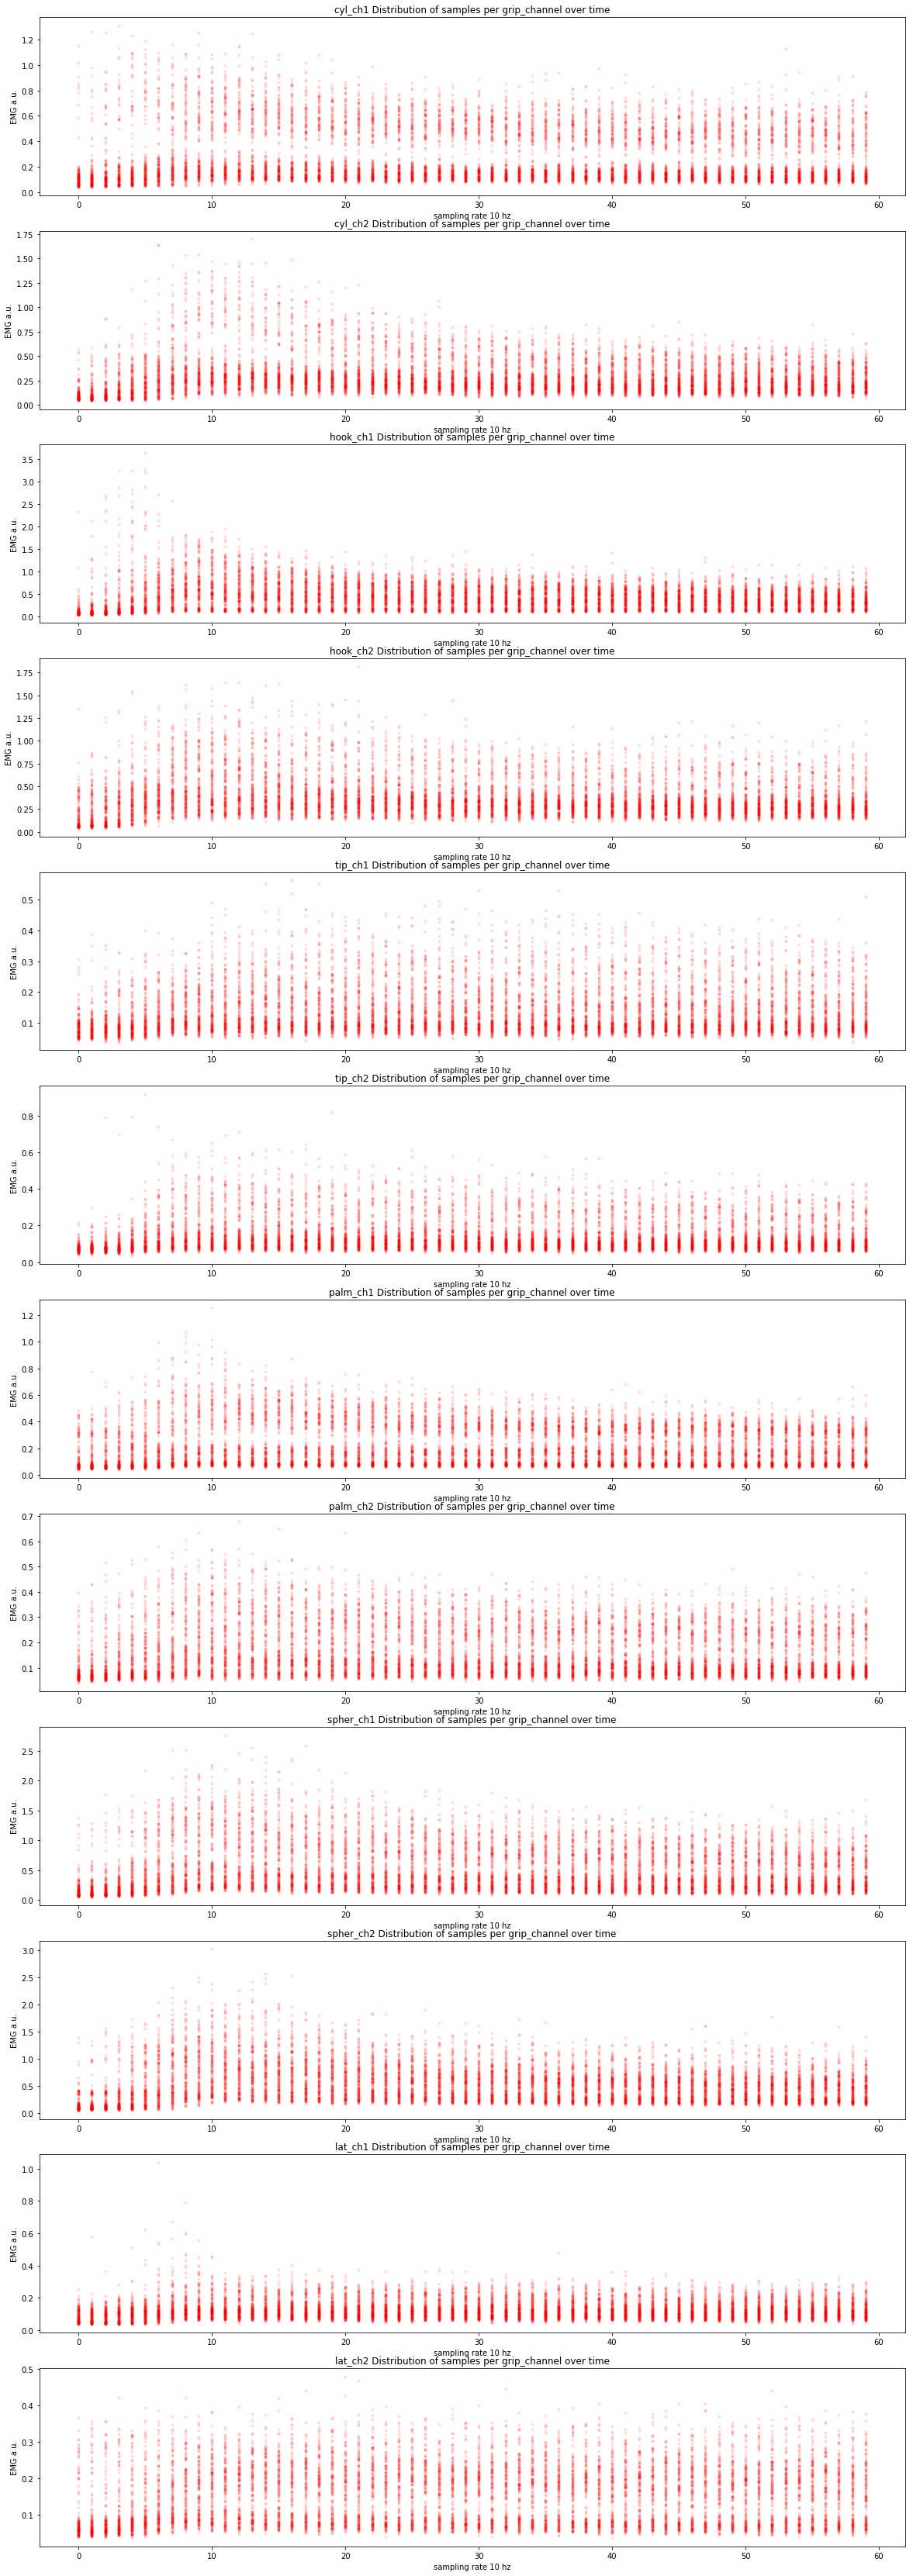

In [23]:
#list of of the grip_channel values
grip_channels = df_amp_adj['grip_channel'].unique()

subplot = 1

plt.figure(figsize=(20,60))

#loop over each grip
for i in grip_channels:
    grip_df = df_amp_adj.loc[df_amp_adj['grip_channel'] == i]
    plt.subplot(12, 1, subplot)
    #loop over and plot sample distribution for that grip
    for index, row in grip_df.iloc[:,:60].iterrows():
        plt.plot(np.array(row),c='r', linestyle='None', marker='.', alpha=0.1)
    plt.title('{} Distribution of samples per grip_channel over time'.format(i))
    plt.xlabel('sampling rate 10 hz')
    plt.ylabel('EMG a.u.')
    subplot += 1

This is less promising to see. It appears that at any given time the distribution of any cross section appears to be skewed to the right, and in fact several of the grip channels exhibited what looked like two populations. Since speed and force are not a constant between readings within each `grip_channel`, we can see that explaining the distribution will be challenging (could they be different by sex?). At any rate, at any cross section of any grip channel, we cannot assume a normal distribution. 

## Kruskal–Wallis one-way ANOVA test
Since we cannot assume a normal distribution, the test we pick must not assume a normal distribution. The Kruskal–Wallis H test, or one-way ANOVA on ranks, is a non-parametric method for testing whether samples originate from the same distribution by comparing the median values. We wish to test and see if the signals by grip are each populations that are statistically different from each other, thus our null hypothesis should be that the medians of each group of signals by grip are statistically similar. A significant Kruskal–Wallis test will indicates that the samples come from different populations, thus rejecting the null hypothesis. Using a moving Kruskal H test (which I'm not entirely sure is a thing but I can't come up with anything better), we can observe where the samples per `grip_channel` might be considered part of the same population. 

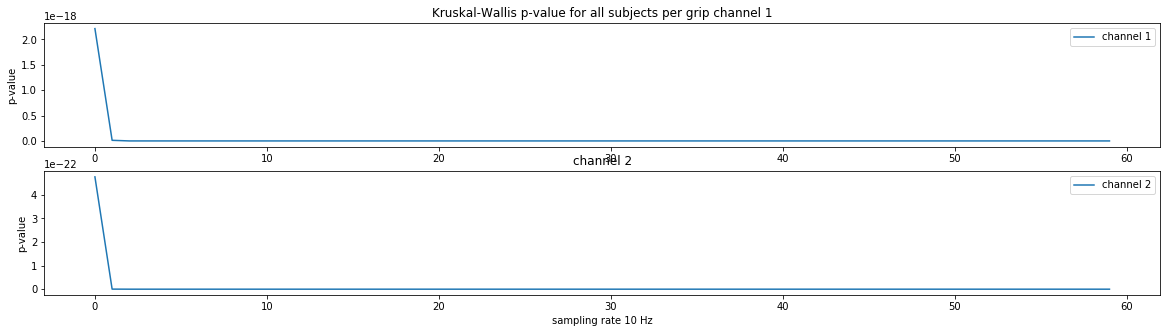

In [24]:
#group by grip channel
plt.figure(figsize=(20,5))

plt.subplot(2,1,1)

# store each corresponding column of each 5 subjects in nested list
total_arrays = []
column = 0
#loop over all columns
while column <= 59:
    #store corresponding column from each subject one by one
    array_list = []
    #grab i column from each grip df
    for grip, data in grips_all[::2]:
        array_list.append(np.array(data['{}'.format(column)]))
    total_arrays.append(array_list)
    column += 1
#store p values per grip here
p_values = []
#calculate p-value for each column of the 5 subjects
for i in total_arrays:
    one, two, three, four, five, six = i
    f, p = sp.stats.kruskal(one, two, three, four, five, six)
    p_values.append(p)
#plot
plt.plot(p_values, label='channel 1')

plt.title('Kruskal-Wallis p-value for all subjects per grip channel 1')
plt.ylabel('p-value')
plt.legend()

#do it again for channel 2
plt.subplot(2,1,2)

total_arrays2 = []
column2 = 0
#loop over all columns
while column2 <= 59:
    #store corresponding column from each subject one by one
    array_list2 = []
    for grip, data in grips_all[1::2]:
        array_list2.append(np.array(data['{}'.format(column2)]))
    total_arrays2.append(array_list2)
    column2 += 1
#store p values per grip here
p_values2 = []
#calculate p-value for each column of the 5 subjects
for i in total_arrays2:
    one, two, three, four, five, six = i
    f, p = sp.stats.kruskal(one, two, three, four, five, six)
    p_values2.append(p)
#plot
plt.plot(p_values2, label='channel 2')
    
plt.title('channel 2')
plt.xlabel('sampling rate 10 Hz')
plt.ylabel('p-value')
plt.legend()

According to this test, we reject the null hypothesis and assume that the signals grouped by `grip_channel` are from seperate distributions. This is a good start, but we need to confirm a few more things to support the idea that a baseline can be calculated from the population we have observed here.

## Are the signals of each subject grouped by grip statistically similar?
In this situation we wish to prove that signals collected from each subject within each grip grouping are actually from the same population. In other words, when we test the samples, we wish to accept the null hypothesis: that each subjects signals within a grip grouping are not statistically different and are indeed from the same population. Before running a test to see whether the signals are similar by subject within each grip group, we must check the distribution of each subjects signals within that group to determine which test will be appropriate, which I will do by comparing the mean of the signals against the subject's interquartile range.

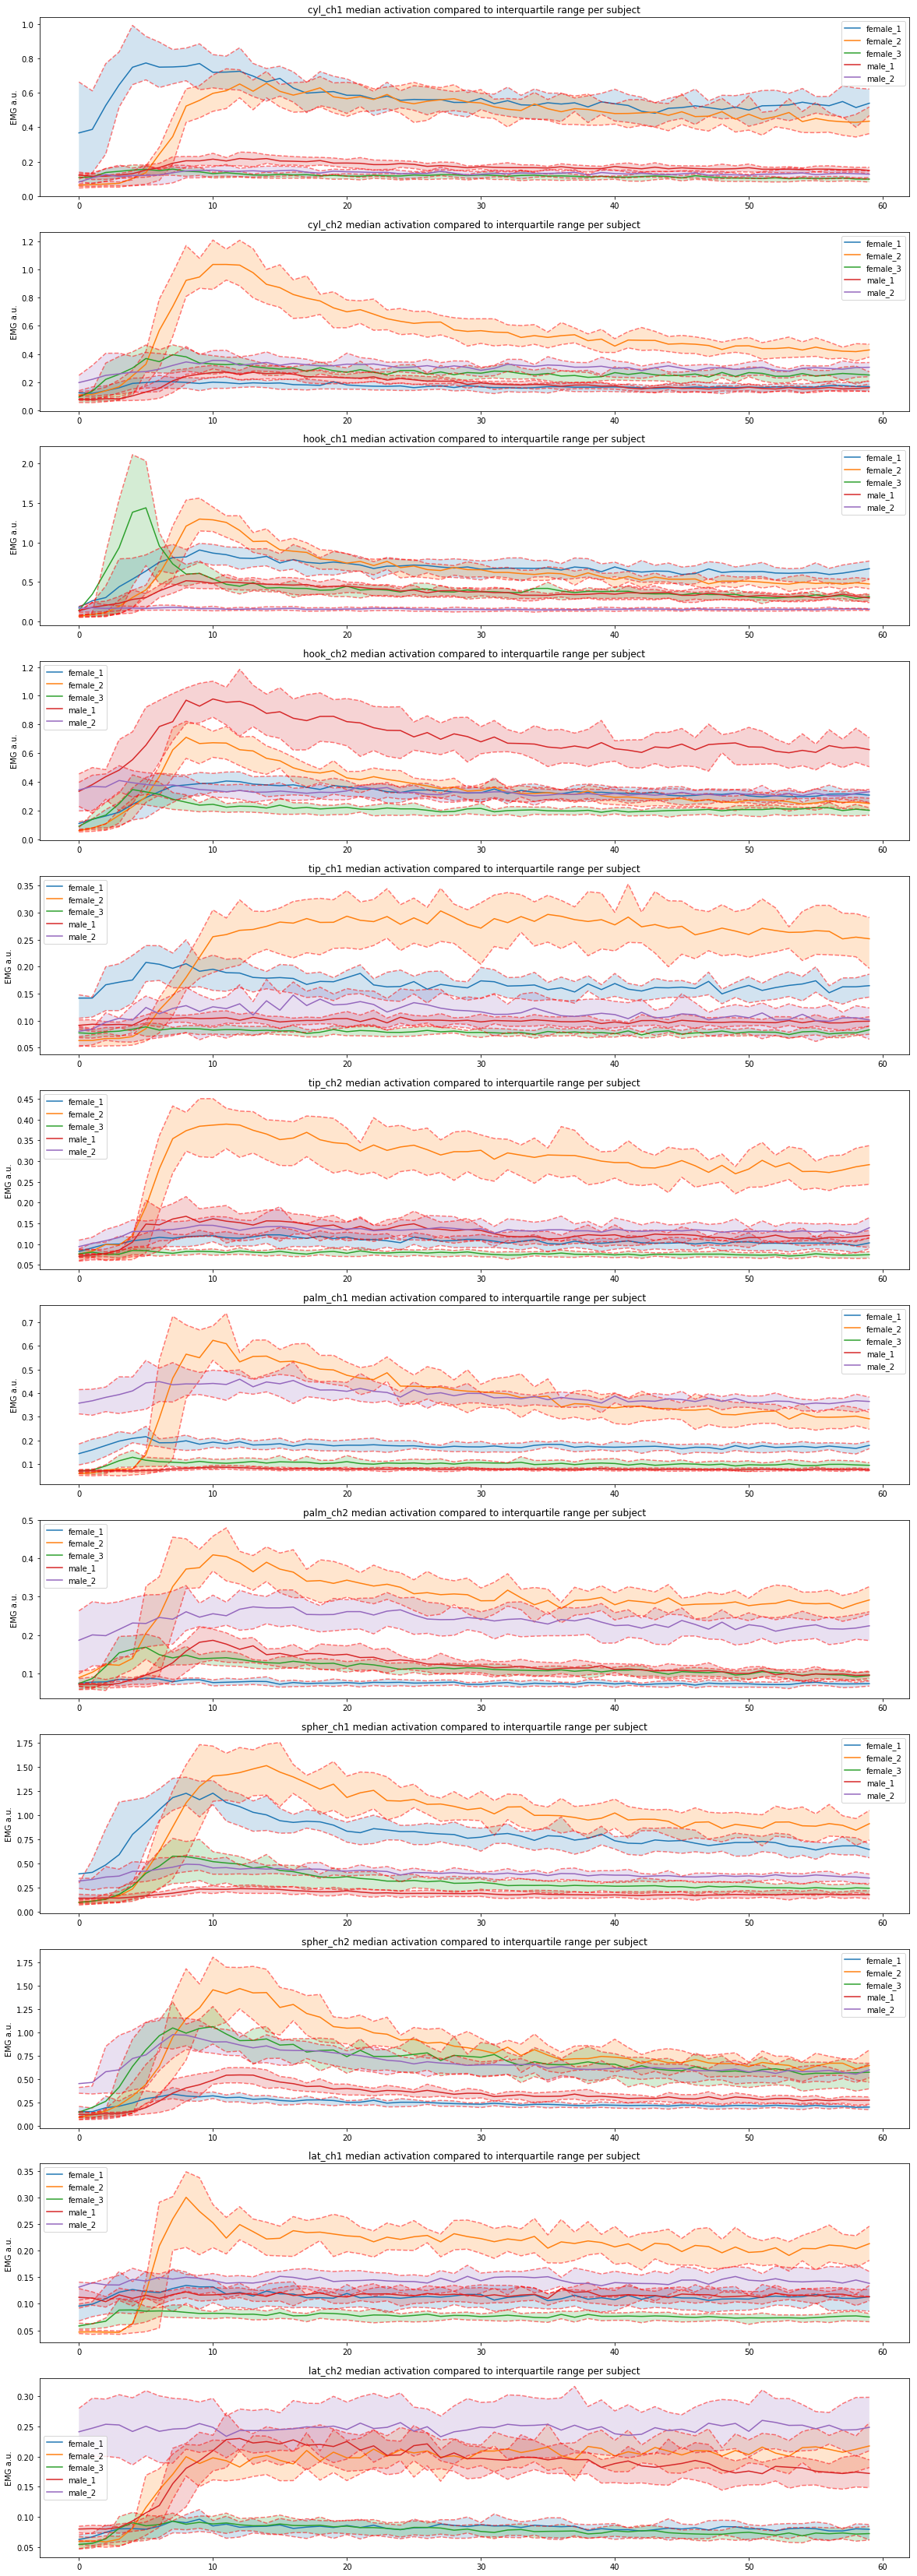

In [25]:
grip_channels = df_amp_adj['grip_channel'].unique()

subplot = 1

plt.figure(figsize=(20,60))

#loop over each grip
for i in grip_channels:
    grip_df = df_amp_adj.loc[df_amp_adj['grip_channel'] == i]
    #group by subject
    gripby_subject = [z for z in grip_df.groupby(grip_df['subject'])]
    plt.subplot(12, 1, subplot)
    #loop over and plot each subjects mean/interquartile range for that grip
    for x, y in gripby_subject:
        means = []
        bottoms = []
        tops = []
        #caluclate mean and conf int for each column
        for column in y.iloc[:,:60]:
            mean = np.mean(np.array(y[column]))
            bottom, top = np.percentile(np.array(y[column]), [25, 75])
            means.append(mean)
            bottoms.append(bottom)
            tops.append(top)
            
        graph_signals([means], [bottoms], [tops], label= x, num_of_samples=60)
        plt.title('{} median activation compared to interquartile range per subject'.format(i))
        plt.ylabel('EMG a.u.')
        plt.legend()
    subplot += 1

Without making a thousand boxplots, it looks like each subjects signals grouped by grip are adhering to the central limit theory in that the mean of the signals seems to trend in the center of the interquartile range, meaning that the samples are normally distributed; however the standard deviatons are varying between the distributions so we will have to settle for a Kruskal Wallis H test again. 

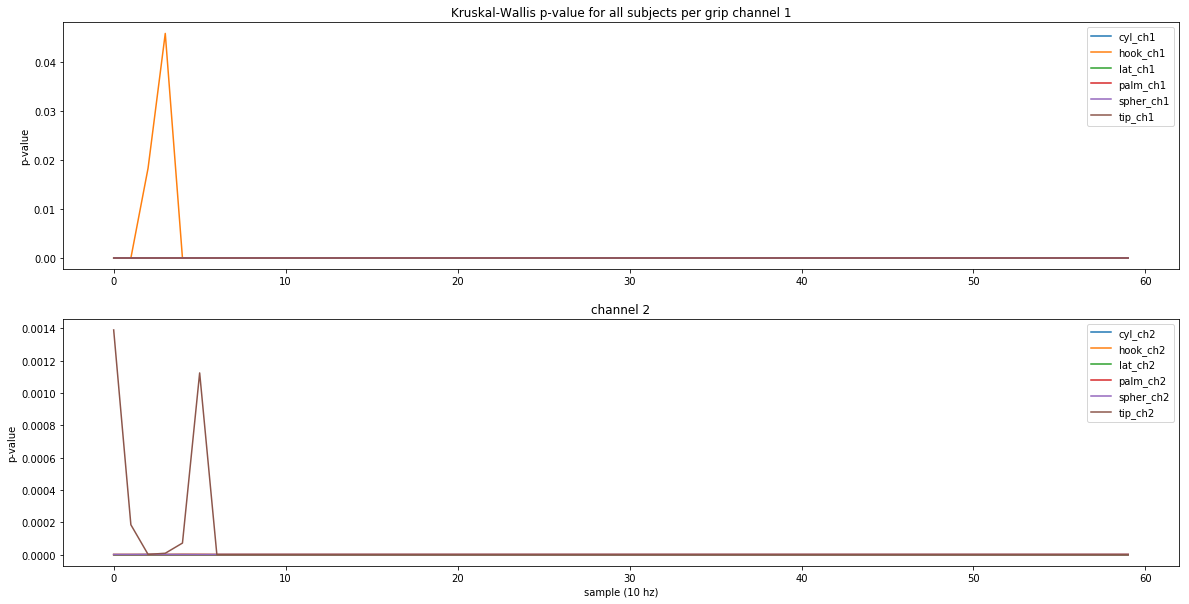

In [26]:
import statsmodels.stats.weightstats

mean_grip_ch1 = df_amp_adj.loc[df_amp_adj['channel'] == 1].groupby('grip_channel').mean()
mean_grip_ch2 = df_amp_adj.loc[df_amp_adj['channel'] == 2].groupby('grip_channel').mean()


plt.figure(figsize=(20,10))

plt.subplot(2,1,1)

for x, y in grips_all[::2]:
    #group by subject
    gripby_subject = [z for z in y.groupby(y['subject'])]
    # store each corresponding column of each 5 subjects in nested list
    total_arrays = []
    column = 0
    #loop over all columns
    while column <= 59:
        #store corresponding column from each subject one by one
        array_list = []
        for subject, data in gripby_subject:
            array_list.append(np.array(data['{}'.format(column)]))
        total_arrays.append(array_list)
        column += 1
    #store p values per grip here
    p_values = []
    #calculate p-value for each column of the 5 subjects
    for i in total_arrays:
        one, two, three, four, five = i
        f, p = sp.stats.kruskal(one, two, three, four, five)        
        p_values.append(p)
        index+=1
    #plot
    plt.plot(p_values, label=x)

plt.title('Kruskal-Wallis p-value for all subjects per grip channel 1')
plt.ylabel('p-value')
plt.legend()

plt.subplot(2,1,2)

for x, y in grips_all[1::2]:
    #group by subject
    gripby_subject = [z for z in y.groupby(y['subject'])]
    # store each corresponding column of each 5 subjects in nested list
    total_arrays = []
    column = 0
    #loop over all columns
    while column <= 59:
        #store corresponding column from each subject one by one
        array_list = []
        for subject, data in gripby_subject:
            array_list.append(np.array(data['{}'.format(column)]))
        total_arrays.append(array_list)
        column += 1
    #store p values per grip here
    p_values = []
    #calculate p-value for each column of the 5 subjects
    for i in total_arrays:
        one, two, three, four, five = i
        f, p = sp.stats.kruskal(one, two, three, four, five)        
        p_values.append(p)
        index+=1
    #plot
    plt.plot(p_values, label=x)
    
plt.title('channel 2')
plt.ylabel('p-value')
plt.xlabel('sample (10 hz)')
plt.legend()

This unfortunately is a bad sign, as it seems to signify that each subjects samples within a grip grouping are actually from seperate distributions and are not part of the same population, thus failing our second criteria.

